<a href="https://colab.research.google.com/github/mr-madmaxx/project-steel/blob/main/project_steel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Required modules for data reading and handling

import pandas as pd

import numpy as np
pd.options.mode.chained_assignment = None
from IPython.display import display

#Required modules for data visualization
import matplotlib.pyplot as plt

import seaborn as sns

#Required modules for Time series forecasting

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

#from statsmodels.tsa.arima model.ARIMAResults import plot predict
from statsmodels.graphics.tsaplots import plot_predict

#Required modules for Evalution of our model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Required modules for visualizing AR plots

import statsmodels.api as sm
import statsmodels.tsa.api as smt

#Module to ignore warnings

import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Reading our data

df1 = pd.read_excel('/content/drive/MyDrive/ml lab/break_down_data_2009to2014.xls')
df2 = pd.read_excel('/content/drive/MyDrive/ml lab/break_down_data_2015to2018 (1).xls')

# Combining the data from two csv files to one
df = pd.concat([df1,df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45482 entries, 0 to 16704
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0                     45482 non-null  int64         
 1   DEPT_CODE         45482 non-null  int64         
 2   ENGG_DIVN_CODE    45482 non-null  int64         
 3   YEAR              45482 non-null  int64         
 4   BD_FIR_SLNO       45482 non-null  int64         
 5   WO_NO             0 non-null      float64       
 6   SECTION_CODE      45482 non-null  int64         
 7   JLP_TYPE          0 non-null      float64       
 8   MP_SLNO           0 non-null      float64       
 9   EQPT_TYPE         45482 non-null  int64         
 10  EQPT_SLNO         45482 non-null  int64         
 11  ASSY_NO           45482 non-null  int64         
 12  SIM_ASSY_ID       45482 non-null  object        
 13  BD_DESC           45482 non-null  object        
 14  SHIFT_CODE        4548

In [ ]:
# Choosing the varaible we want to forecast
data=df[['BD_DATE', 'DEPT_CODE']]
data['BD_DATE'] = pd.to_datetime (data['BD_DATE'], errors='coerce')
data = data.sort_values('BD_DATE')
data = data.dropna()
data.head()

,BD_DATE,DEPT_CODE
393,1999-01-03,36
13649,2001-01-12,37
12061,2001-04-24,49
1151,2006-03-07,33
7848,2006-06-18,34


In [ ]:
# Discarding data before 2008 year and reseting the index of our dataframe
condition = pd.to_datetime('2008-12-31')

data = data[(data['BD_DATE']>condition)]
data.reset_index(drop=True, inplace=True)

display(data.head())

# Resampling our data to find out the number of breakdowns per week irrespective of the department
data.set_index('BD_DATE', inplace=True)
final_data = data.resample('D').count()
final_data.columns = ['BD_COUNT']

,BD_DATE,DEPT_CODE
0,2009-01-01,54
1,2009-01-01,30
2,2009-01-01,30
3,2009-01-01,37
4,2009-01-01,30


In [ ]:
# Handling outliers by replacing the top 1% and bottom 1% values to normal range
from scipy.stats.mstats import winsorize
winsorized_data = winsorize(final_data['BD_COUNT'], limits = [0.01, 0.01])
processed_data = final_data.copy()
processed_data['BD_COUNT'] = winsorized_data

In [ ]:
#Function to perform Rol Ling-Statistics and Dicky-Fuller test
def test_stationarity (timeseries):
  #Determing rolling statistics
  MA = timeseries.rolling (window=365).mean()
  MSTD = timeseries.rolling (window=365).std()
  #Plot rolling statistics:
  plt.figure(figsize=(15,5))
  orig= plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(MA, color='red', label='Rolling Mean')
  std= plt.plot (MSTD, color='black', label='Rolling Std')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)
  plt.legend(loc='best')
  #Perform Dickey-Fuller test: print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd. Series (dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of observations used'])
  for key, value in dftest [4].items():
    dfoutput['Critical value (%s) '%key] = value
  print(dfoutput)

In [ ]:
# Function to plot ACF and PACF graph
def tsplot(y, lags=None, figsize=(15, 5), style='bmh'):
  if not isinstance(y, pd.Series):
    y = pd.Series(y)
  with plt.style.context (style):
    fig = plt.figure(figsize=(10,15))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid (layout, (1, 0))
    pacf_ax = plt.subplot2grid (layout, (1, 1))
    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller (y)[1]
    ts_ax.set_title('Time Series Analysis Plots \n Dickey-Fuller: p-{0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

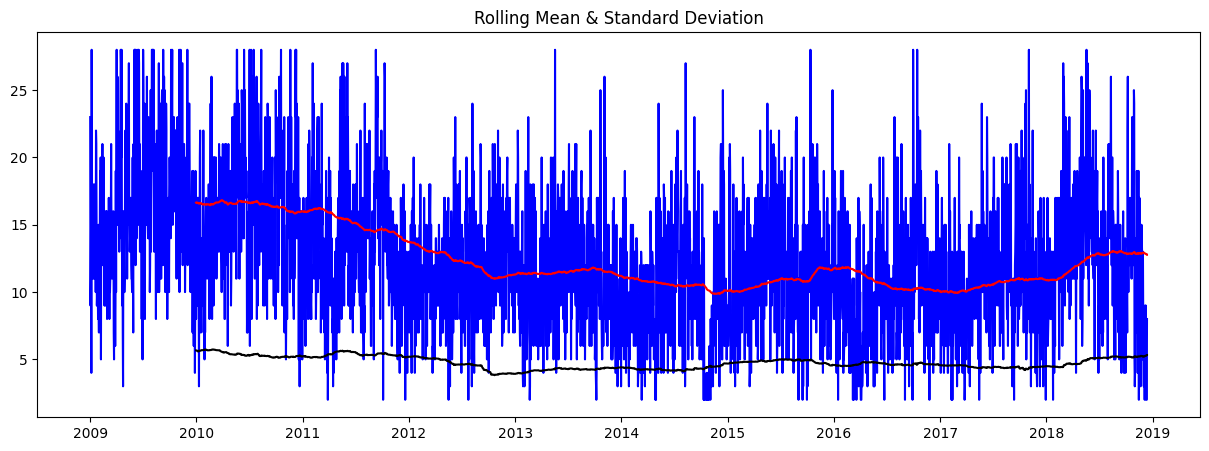

Test Statistic                   -4.570674
p-value                           0.000146
#Lags used                       30.000000
Number of observations used    3603.000000
Critical value (1%)              -3.432166
Critical value (5%)              -2.862343
Critical value (10%)             -2.567197
dtype: float64


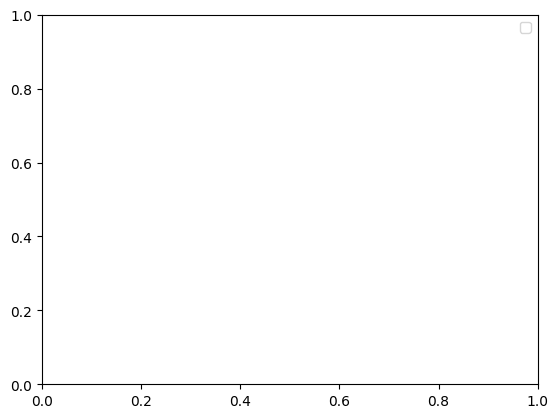

In [ ]:
#Performing stationary tests on our processed data
test_stationarity(processed_data)

In [ ]:
# Splitting our dataset into training and testing purpose
traindata = pd.DataFrame(processed_data[:3287])
testdata = pd.DataFrame(processed_data[3287:])
testdata.head()

,BD_COUNT
BD_DATE,
2018-01-01,13
2018-01-02,7
2018-01-03,8
2018-01-04,7
2018-01-05,17


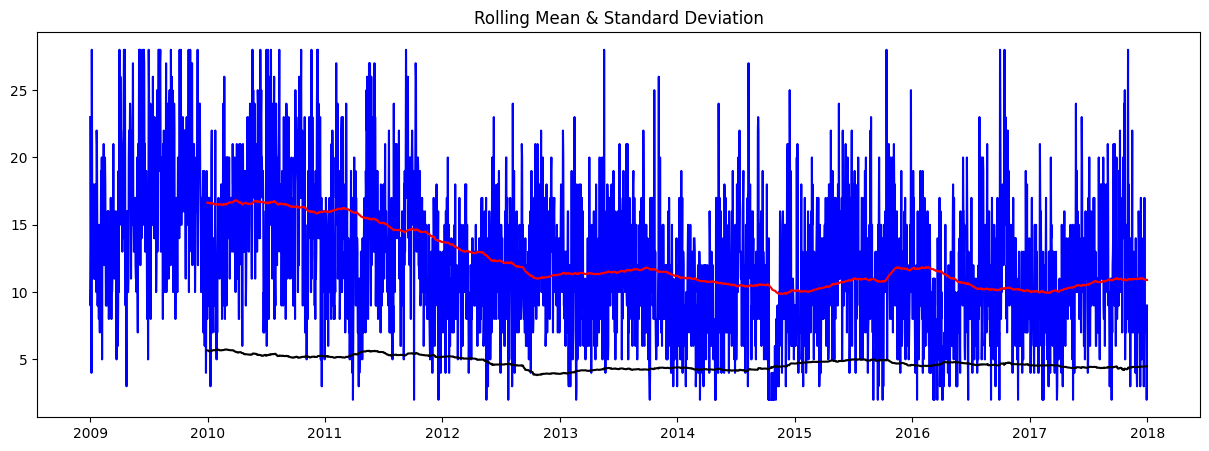

Test Statistic                   -4.534899
p-value                           0.000170
#Lags used                       27.000000
Number of observations used    3259.000000
Critical value (1%)              -3.432358
Critical value (5%)              -2.862427
Critical value (10%)             -2.567242
dtype: float64


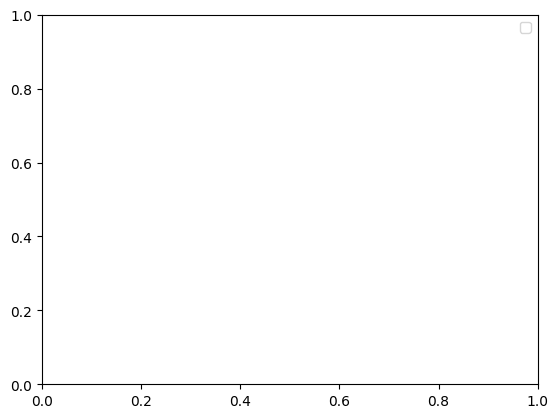

In [ ]:
#Performing stationarity tests on our training data
test_stationarity (traindata)

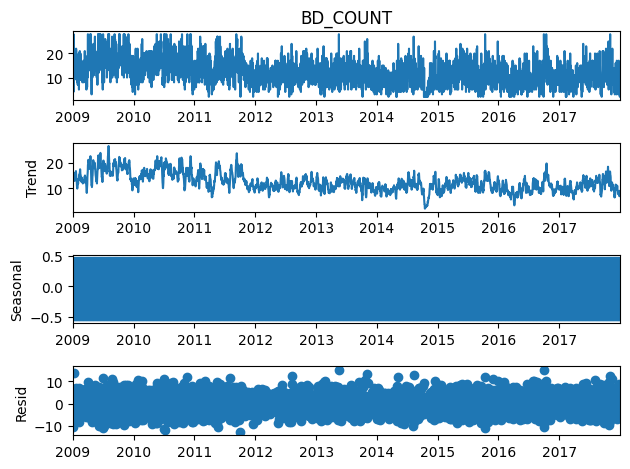

In [ ]:
# Decomposing our data
dec = sm.tsa.seasonal_decompose(traindata['BD_COUNT'], model = 'additive').plot()
plt.show()

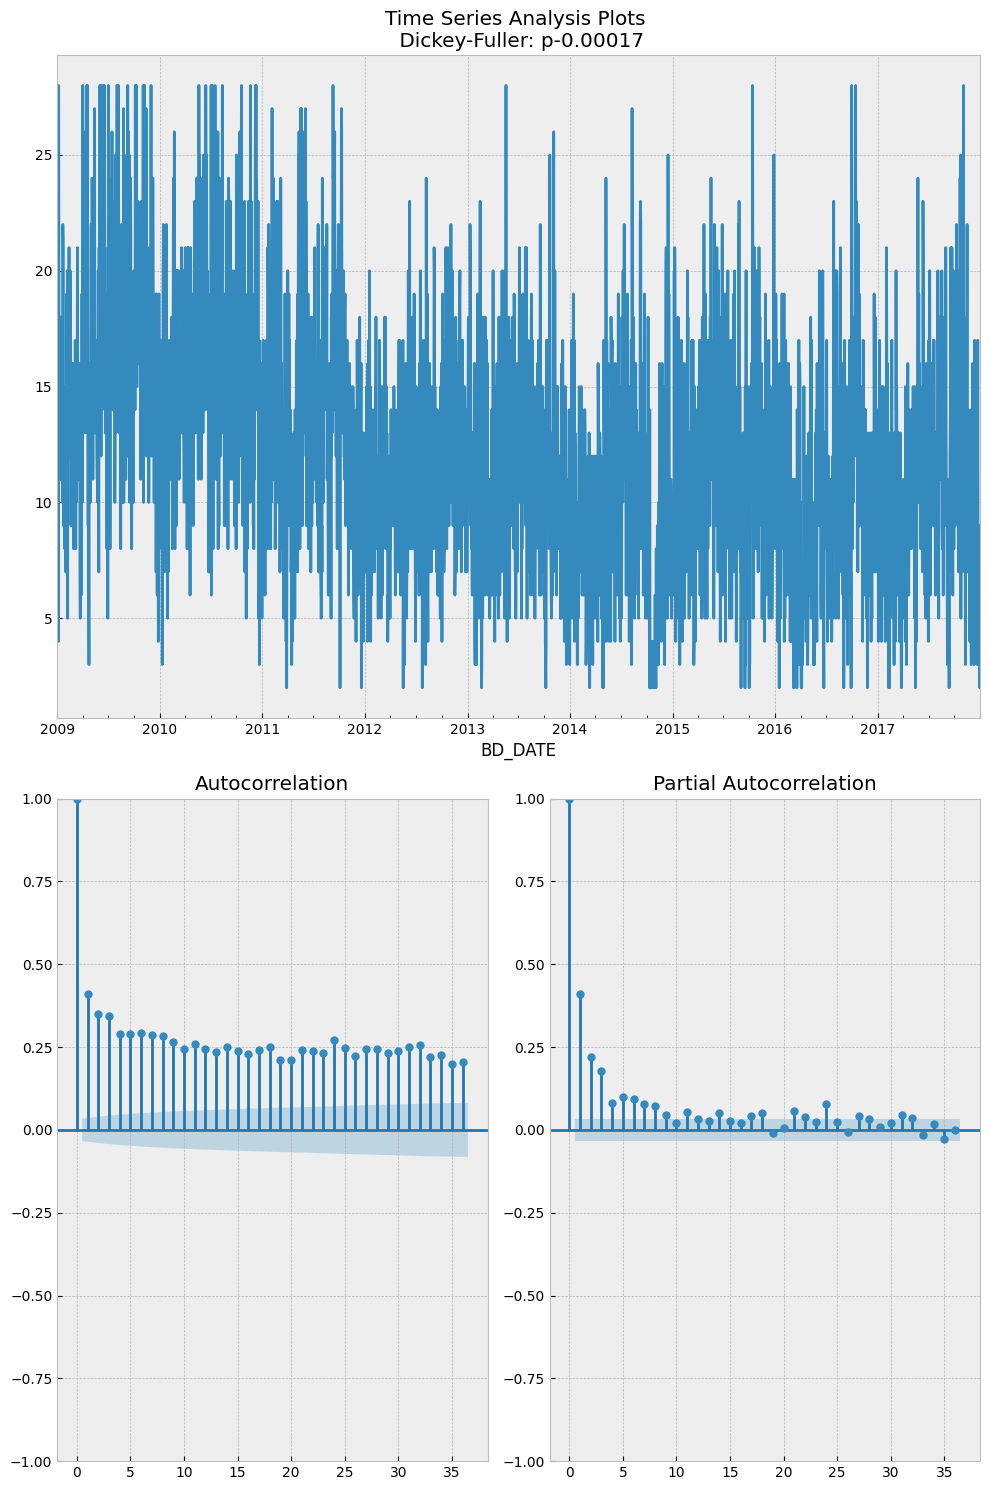

In [ ]:
# Plotting ACF and PACF graphs to find out the values of p and q for ARIMA
tsplot(traindata['BD_COUNT'])

In [ ]:
# From the ACF graph, we obtain q=5
# From the PACF graph, we obtain p=5
# We will take d=0 zero as we did not perform any differencing
#p=5;q=5;d=0
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(traindata['BD_COUNT'],order = (5,0,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               BD_COUNT   No. Observations:                 3287
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -9619.683
Date:                Thu, 27 Jul 2023   AIC                          19263.367
Time:                        13:31:52   BIC                          19336.539
Sample:                    01-01-2009   HQIC                         19289.565
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3694      0.864     14.314      0.000      10.676      14.063
ar.L1         -0.2406      0.204     -1.178      0.239      -0.641       0.160
ar.L2          0.6946      0.157      4.422      0.0

MAE: 3.590084830700001
MSE: 20.40662156302248


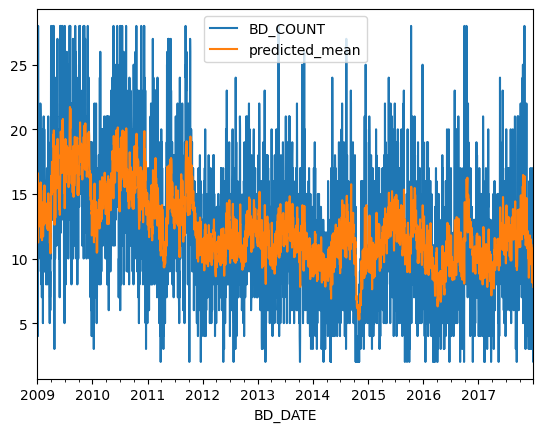

In [ ]:
# MODEL EVALUATION on TRAINING DATA
# Make predictions on the training data
train_pred = model_fit.predict(start=traindata.index[0],end=traindata.index[-1])
# Calculate mean absolute error and mean squared error
mae = mean_absolute_error(traindata['BD_COUNT'], train_pred)
mse = mean_squared_error(traindata['BD_COUNT'], train_pred)
print('MAE:', mae)
print('MSE:', mse)
traindata.plot()
train_pred.plot()
plt.legend()

MAE: 3.590084830700001
MSE: 20.40662156302248


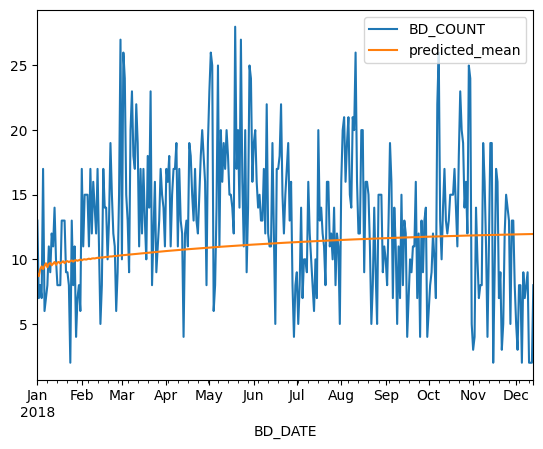

In [ ]:
# MODEL EVALUATION on TESTING DATA
# Make predictions on the training data
test_pred = model_fit.predict(start =testdata.index[0],end=testdata.index[-1])
# Calculate mean absolute error and mean squared error mae = mean_absolute_error(testdata['BD_COUNT'], test_pred) mse = mean_squared_error(testdata['BD_COUNT'], test_pred)
print('MAE:', mae)
print('MSE:', mse)
testdata.plot()
test_pred.plot()
plt.legend()

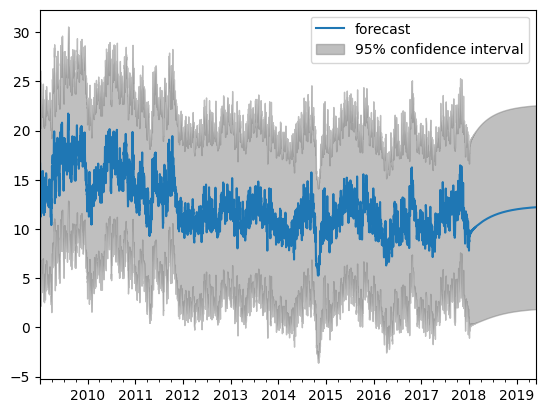

In [ ]:
# Forecasting using our model
plot_predict(model_fit,1,3800)
plt.show()

In [ ]:
import pickle
with open('arima_model.pkl', 'wb') as file:
  pickle.dump(model_fit, file)

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.9 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=fc5c9916b15263448df6b20290291aefcfa6e83a0a42dba0ca99170d8df95ed8
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzloca

In [ ]:
import streamlit as st
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_model import ARIMA

with open('arima_model.pkl', 'rb') as file:
  model_fit=pickle.load(file)
st.set_page_config (layout="wide")
st.title(" Prediction of number of Breakdowns with ARIMA Model")
#Input form for user to enter values
st.header("How many days you want to forecast?")
p = st.number_input("days", min_value=0, max_value=365, step=1)
coll, col2 = st.columns (2)
#Generate predictions based on user input
if st.button("Generate Predictions"):
 #Perform prediction using the ARIMA model
 #fig, axes= plt.subplots()
 with coll:
   st.pyplot(plot_predict(model_fit,1,3290+p))
 with col2:
   st.header("Predictions")
 if p==0:
    st.write('Zero Predictions')
 else:
    forecasts = model_fit. forecast (p)
 # Display the predictions
    st.write (forecasts)